In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, TensorDataset,random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Load ground truth and reconstructed helsinki images
ground_truth_path = "/kaggle/input/limited-helsinki/scaled_ground90deg181.pt"
recon_ellipses_path = "/kaggle/input/limited-helsinki/scaled_recon90deg181.pt"
reconstructed_images = torch.load(recon_ellipses_path)
ground_truth_images = torch.load(ground_truth_path)
 
# Reshaping images to [batch, channels, height, width]    
ground_truth_images = ground_truth_images.view(-1,1,512,512)
reconstructed_images = reconstructed_images.view(-1,1,512,512)

dataset = TensorDataset(reconstructed_images ,ground_truth_images)

In [3]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))   
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,drop_last=True)

3200
800


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder layers
        self.initial_conv = DoubleConv(n_channels, 64)
        self.downsample1 = nn.MaxPool2d(2)
        self.conv_block1 = DoubleConv(64, 128)
        self.downsample2 = nn.MaxPool2d(2)
        self.conv_block2 = DoubleConv(128, 256)
        self.downsample3 = nn.MaxPool2d(2)
        self.conv_block3 = DoubleConv(256, 512)

        # Attention Gates
        self.attention_gate1 = AttentionGate(F_g=256, F_l=128, F_int=64)  # Adjusted to match layer sizes
        self.attention_gate2 = AttentionGate(F_g=128, F_l=64, F_int=32)   # Adjusted to match layer sizes

        # Decoder layers
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_block4 = DoubleConv(512, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_block5 = DoubleConv(256, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_block6 = DoubleConv(128, 64)
        
        self.output_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x3 = self.conv_block1(x2)
        x4 = self.downsample2(x3)
        x5 = self.conv_block2(x4)
        x6 = self.downsample3(x5)
        x7 = self.conv_block3(x6)

        # Upsample and apply attention
        x8 = self.upsample1(x7)
        x8 = torch.cat([x8, x5], dim=1)
        x9 = self.conv_block4(x8)
        x10 = self.upsample2(x9)
        x10 = torch.cat([x10, x3], dim=1)
        x11 = self.conv_block5(x10)
        x12 = self.upsample3(x11)
        x12 = torch.cat([x12, x1], dim=1)
        x13 = self.conv_block6(x12)

        # Output layer
        logits = self.output_conv(x13)
        return logits

In [6]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1, 1).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
training_losses = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
    training_losses.append(loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
torch.save(model.state_dict(), 'attunetonhelsinki4000.pth')

100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [1/20], Loss: 0.001143


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [2/20], Loss: 0.000597


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [3/20], Loss: 0.000388


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [4/20], Loss: 0.000423


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [5/20], Loss: 0.000312


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [6/20], Loss: 0.000296


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [7/20], Loss: 0.000237


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [8/20], Loss: 0.000312


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [9/20], Loss: 0.000293


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [10/20], Loss: 0.000258


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [11/20], Loss: 0.000219


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [12/20], Loss: 0.000364


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [13/20], Loss: 0.000326


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [14/20], Loss: 0.000160


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [15/20], Loss: 0.000224


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [16/20], Loss: 0.000224


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [17/20], Loss: 0.000148


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [18/20], Loss: 0.000190


100%|██████████| 800/800 [04:39<00:00,  2.86it/s]


Epoch [19/20], Loss: 0.000775


100%|██████████| 800/800 [04:39<00:00,  2.87it/s]


Epoch [20/20], Loss: 0.000235


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Average SSIM: 0.9239
Average PSNR: 27.5436
Average SSIM: 0.3886
Average PSNR: 9.7295


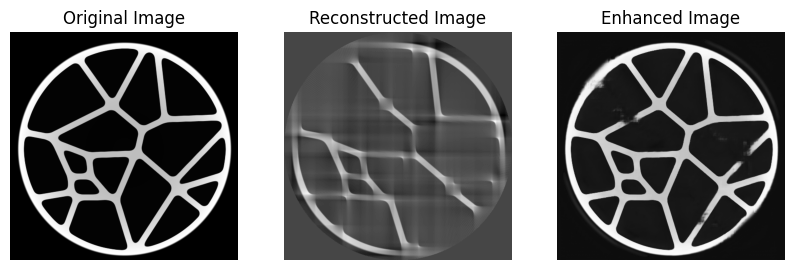

In [7]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')


In [8]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  7733223


In [9]:
print(model)

UNet(
  (initial_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     